- [Предобработка](#Предобработка)
- [Label Encoding](#Label-Encoding)
- [One-Hot Encoding](#One-Hot-Encoding)
- [Multi-Class Target Encoding](#Multi-Class-Target-Encoding)

In [1]:
import os
import subprocess

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from utils import definitions as defs

In [2]:
RANDOM_STATE = 42
TRAIN_SIZE = 0.7

In [3]:
df = pd.read_excel(defs.ETLED_DATA_PATH)

## Предобработка

In [4]:
Y = df[defs.LABEL]
X = df.drop(defs.LABEL, axis=1)

In [5]:
feature_names = list(X)

Меняем NaN на -1 в численных признаках.

In [6]:
X.replace({defs.QUESTION_2: {np.NaN: -1}}, inplace=True)
X.replace({defs.QUESTION_4: {np.NaN: -1}}, inplace=True)
X.replace({defs.QUESTION_22: {np.NaN: -1}}, inplace=True)
X.replace({defs.QUESTION_24: {np.NaN: -1}}, inplace=True)

Кодируем ранговые признаки.

In [7]:
X.replace({
    defs.QUESTION_5:
    {
        np.NaN: -1,
        defs.ANSWER_5_5: 0,
        defs.ANSWER_5_4: 1,
        defs.ANSWER_5_3: 2,
        defs.ANSWER_5_2: 3,
        defs.ANSWER_5_1: 4,
    }
}, inplace=True)

X.replace({
    defs.QUESTION_7:
    {
        np.NaN: -1,
        defs.ANSWER_7_6: 0,
        defs.ANSWER_7_5: 1,
        defs.ANSWER_7_4: 2,
        defs.ANSWER_7_3: 3,
        defs.ANSWER_7_2: 4,
        defs.ANSWER_7_1: 5,
    }
}, inplace=True)

X.replace({defs.QUESTION_9:{np.NaN: -1}}, inplace=True)
X[defs.QUESTION_9] = X[defs.QUESTION_9].astype('int64')

X.replace({
    defs.QUESTION_11:
    {
        np.NaN: -1,
        defs.ANSWER_11_6: 0,
        defs.ANSWER_11_5: 1,
        defs.ANSWER_11_4: 2,
        defs.ANSWER_11_3: 3,
        defs.ANSWER_11_2: 4,
        defs.ANSWER_11_1: 5,
    }
}, inplace=True)

X.replace({
    defs.QUESTION_12:
    {
        np.NaN: -1,
        defs.ANSWER_12_1: 0,
        defs.ANSWER_12_2: 1,
        defs.ANSWER_12_3: 2,
        defs.ANSWER_12_4: 3,
    }
}, inplace=True)

X.replace({
    defs.QUESTION_13:
    {
        np.NaN: -1,
        defs.ANSWER_13_5: 0,
        defs.ANSWER_13_4: 1,
        defs.ANSWER_13_6: 2,
        defs.ANSWER_13_7: 3,
        defs.ANSWER_13_3: 4,
        defs.ANSWER_13_2: 5,
        defs.ANSWER_13_1: 6,
    }
}, inplace=True)

X.replace({
    defs.QUESTION_14:
    {
        np.NaN: -1,
        defs.ANSWER_14_4: 0,
        defs.ANSWER_14_3: 1,
        defs.ANSWER_14_2: 2,
        defs.ANSWER_14_1: 3,
    }
}, inplace=True)

X.replace({defs.QUESTION_16:{np.NaN: -1}}, inplace=True)
X.replace({defs.QUESTION_17:{np.NaN: -1}}, inplace=True)
X.replace({defs.QUESTION_18:{np.NaN: -1}}, inplace=True)

X.replace({
    defs.QUESTION_19:
    {
        np.NaN: -1,
        defs.ANSWER_19_20_1: 0,
        defs.ANSWER_19_20_2: 1,
        defs.ANSWER_19_20_3: 2,
        defs.ANSWER_19_20_4: 3,
    }
}, inplace=True)

X.replace({
    defs.QUESTION_20:
    {
        np.NaN: -1,
        defs.ANSWER_19_20_1: 0,
        defs.ANSWER_19_20_2: 1,
        defs.ANSWER_19_20_3: 2,
        defs.ANSWER_19_20_4: 3,
    }
}, inplace=True)

X.replace({
    defs.QUESTION_26:
    {
        np.NaN: -1,
        defs.ANSWER_26_1: 0,
        defs.ANSWER_26_2: 1,
        defs.ANSWER_26_3: 2,
    }
}, inplace=True)

X.replace({
    defs.QUESTION_27:
    {
        np.NaN: -1,
        defs.ANSWER_27_4: 0,
        defs.ANSWER_27_3: 1,
        defs.ANSWER_27_2: 2,
        defs.ANSWER_27_1: 3,
    }
}, inplace=True)

X.replace({
    defs.QUESTION_28:
    {
        np.NaN: -1,
        defs.ANSWER_28_4: 0,
        defs.ANSWER_28_3: 1,
        defs.ANSWER_28_2: 2,
        defs.ANSWER_28_1: 3,
    }
}, inplace=True)

X.replace({
    defs.QUESTION_29:
    {
        np.NaN: -1,
        defs.ANSWER_29_4: 0,
        defs.ANSWER_29_3: 1,
        defs.ANSWER_29_2: 2,
        defs.ANSWER_29_1: 3,
    }
}, inplace=True)

Кодируем бинарные признаки.

In [8]:
X.replace({defs.QUESTION_6: {defs.YES: 1, defs.NO: 0}}, inplace=True)
X.replace({defs.QUESTION_8: {defs.YES: 1, defs.NO: 0}}, inplace=True)
X.replace({defs.QUESTION_10: {defs.YES: 1, defs.NO: 0, np.NaN: -1}}, inplace=True)
X.replace({defs.QUESTION_15: {defs.YES: 1, defs.NO: 0, np.NaN: -1}}, inplace=True)
X.replace({defs.QUESTION_30: {defs.YES: 1, defs.NO: 0, np.NaN: -1}}, inplace=True)
X.replace({defs.QUESTION_33: {defs.YES: 1, defs.NO: 0}}, inplace=True)
X.replace({defs.QUESTION_34: {defs.YES: 1, defs.NO: 0}}, inplace=True)
X.replace({defs.QUESTION_35: {defs.YES: 1, defs.NO: 0}}, inplace=True)

## Label Encoding

Кодируем категориальные признаки.

In [9]:
def encode_categorical_feature(df, feature_name, categories):
    # Столбец в DataFrame становится "категориальным". Это означает, что ячейки в нём могут
    # принимать только значения из допустимых категорий либо np.NaN. Допустимые категории
    # определяются при создании такого столбца либо множеством различных ячеек, либо
    # специальным списком. Если допустимые категории определяются специальным списком и 
    # значение ячейки не входит в этот список, её значение становится np.NaN.
    df[feature_name] = pd.Categorical(df[feature_name], categories=categories)
    # Категории кодируются числами 0, 1, 2, ... np.NaN числом -1.
    df[feature_name] = df[feature_name].cat.codes
    # Приведение к типу, допустимому для конвертации DataFrame в Dataset.
    df[feature_name] = df[feature_name].astype('int64')

In [10]:
X_LE = X.copy()

categorical_feature_names = {
    defs.QUESTION_3: defs.ANSWERS_3,
    defs.QUESTION_23: defs.ANSWERS_23,
    defs.QUESTION_25: defs.ANSWERS_25,
}

for feature_name, categories in categorical_feature_names.items():
    encode_categorical_feature(X_LE, feature_name, categories)

#### Обобщающая модель дерева решений

In [11]:
X_LE_train, X_LE_test, Y_train, Y_test = train_test_split(
    X_LE, Y,
    train_size=TRAIN_SIZE,
    stratify=Y,
    random_state=RANDOM_STATE,
)

In [12]:
PARAM_GRID = [
    {
        'min_samples_split': [2],
        'min_samples_leaf': [1],
    },
    {
        'min_samples_split': [4],
        'min_samples_leaf': [1, 2],
    },
    {
        'min_samples_split': [8],
        'min_samples_leaf': [1, 2, 4],
    },
    {
        'min_samples_split': [16],
        'min_samples_leaf': [1, 2, 4, 8],
    },
    {
        'min_samples_split': [32],
        'min_samples_leaf': [1, 2, 4, 8, 16],
    },
    {
        'min_samples_split': [64],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32],
    },
    {
        'min_samples_split': [128],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64],
    },
    {
        'min_samples_split': [256],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 128],
    },
    {
        'min_samples_split': [512],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 128, 256],
    },
]


def cross_validation(param_grid, X_train, Y_train):
    search = GridSearchCV(
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        param_grid,
        refit=True,
        cv=StratifiedShuffleSplit(n_splits=5, random_state=RANDOM_STATE),
    )
    search.fit(X_train, Y_train)

    print('Лучшие гиперпараметры:')
    for param, value in search.best_params_.items():
        print(f'{param}: {value}')
        
    return search.best_estimator_

In [13]:
generalizing_tree = cross_validation(PARAM_GRID, X_LE_train, Y_train)

Лучшие гиперпараметры:
min_samples_leaf: 32
min_samples_split: 128


In [14]:
Y_LE_pred = generalizing_tree.predict(X_LE_test)
print(classification_report(Y_test, Y_LE_pred))

                           precision    recall  f1-score   support

доброкачественная опухоль       0.64      0.80      0.71        60
  злокачественная опухоль       0.49      0.77      0.60        60
                    норма       0.64      0.12      0.20        59

                 accuracy                           0.56       179
                macro avg       0.59      0.56      0.50       179
             weighted avg       0.59      0.56      0.51       179



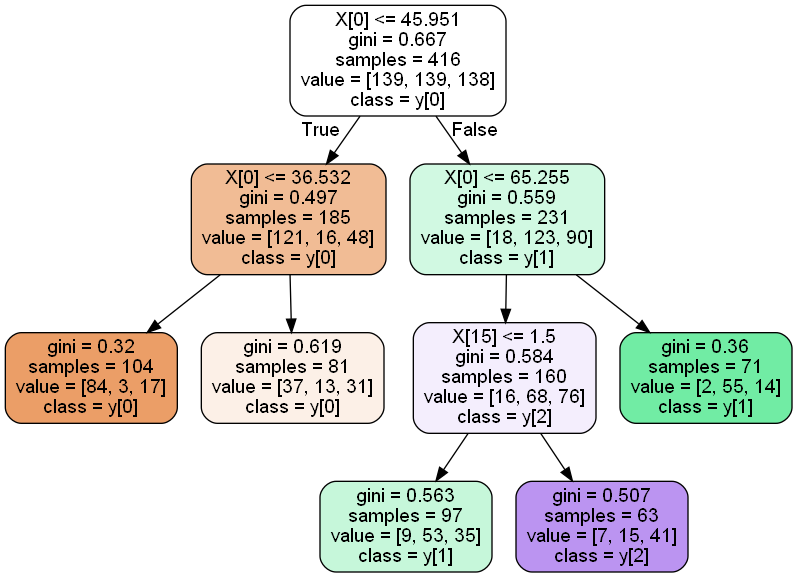

In [15]:
export_graphviz(
    generalizing_tree,
    out_file='generalizing tree.gv',
    class_names=True,
    filled=True,
    rounded=True,
)
# конвертируем из .gv в .png через командую строку
subprocess.call(['dot', '-Tpng', 'generalizing tree.gv', '-o', 'generalizing tree.png'])
display.Image('generalizing tree.png')

In [16]:
# Картинки встроены в jupyter notebook. Теперь удаляем файлы, чтобы они не засоряли проект.
os.remove('generalizing tree.gv')
os.remove('generalizing tree.png')

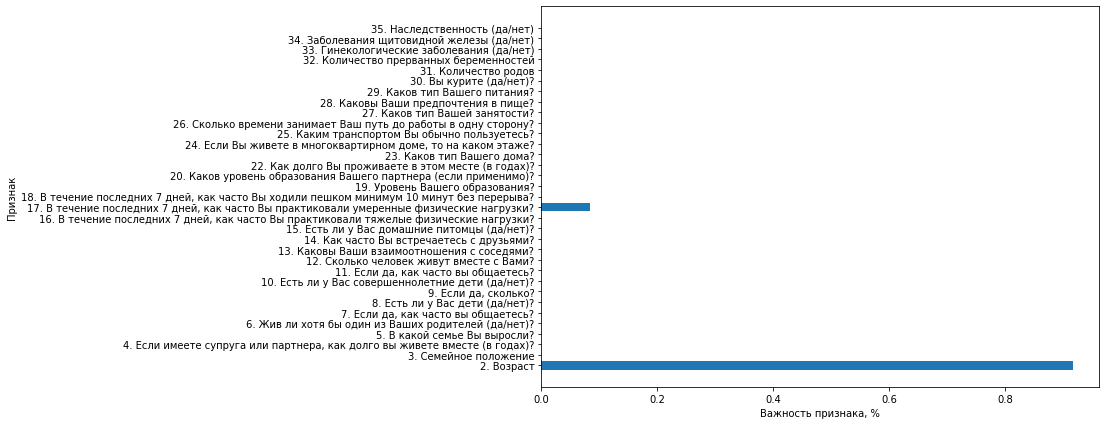

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(feature_names, generalizing_tree.feature_importances_, align='center')
ax.set_xlabel('Важность признака, %')
ax.set_ylabel('Признак')

plt.show() 

## One-Hot Encoding

### кодируются только категориальные

Кодируем категориальные признаки.

In [18]:
X_OHE = X.copy()

X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_3], prefix='вопрос3')], axis=1).drop([defs.QUESTION_3], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_23], prefix='вопрос23')], axis=1).drop([defs.QUESTION_23], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_25], prefix='вопрос25')], axis=1).drop([defs.QUESTION_25], axis=1)

In [19]:
X_OHE_train, X_OHE_test, Y_train, Y_test = train_test_split(
    X_OHE, Y,
    train_size=TRAIN_SIZE,
    stratify=Y,
    random_state=RANDOM_STATE,
)

Кросс-валидации гиперпараметров.

In [20]:
generalizing_tree = cross_validation(PARAM_GRID, X_OHE_train, Y_train)

Лучшие гиперпараметры:
min_samples_leaf: 1
min_samples_split: 8


In [21]:
Y_OHE_pred = generalizing_tree.predict(X_OHE_test)
print(classification_report(Y_test, Y_OHE_pred, zero_division=0))

                           precision    recall  f1-score   support

доброкачественная опухоль       0.59      0.60      0.60        60
  злокачественная опухоль       0.58      0.62      0.60        60
                    норма       0.43      0.39      0.41        59

                 accuracy                           0.54       179
                macro avg       0.53      0.54      0.53       179
             weighted avg       0.53      0.54      0.53       179



### кодируются категориальные и ранговые признаки

Докодируем и ранговые признаки.

In [22]:
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_5], prefix='вопрос5')], axis=1).drop([defs.QUESTION_5], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_7], prefix='вопрос7')], axis=1).drop([defs.QUESTION_7], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_9], prefix='вопрос9')], axis=1).drop([defs.QUESTION_9], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_11], prefix='вопрос11')], axis=1).drop([defs.QUESTION_11], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_12], prefix='вопрос12')], axis=1).drop([defs.QUESTION_12], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_13], prefix='вопрос13')], axis=1).drop([defs.QUESTION_13], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_14], prefix='вопрос14')], axis=1).drop([defs.QUESTION_14], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_19], prefix='вопрос19')], axis=1).drop([defs.QUESTION_19], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_20], prefix='вопрос20')], axis=1).drop([defs.QUESTION_20], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_26], prefix='вопрос26')], axis=1).drop([defs.QUESTION_26], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_27], prefix='вопрос27')], axis=1).drop([defs.QUESTION_27], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_28], prefix='вопрос28')], axis=1).drop([defs.QUESTION_28], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_29], prefix='вопрос29')], axis=1).drop([defs.QUESTION_29], axis=1)

In [23]:
X_OHE_train, X_OHE_test, Y_train, Y_test = train_test_split(
    X_OHE, Y,
    train_size=TRAIN_SIZE,
    stratify=Y,
    random_state=RANDOM_STATE,
)

In [24]:
generalizing_tree = cross_validation(PARAM_GRID, X_OHE_train, Y_train)

Лучшие гиперпараметры:
min_samples_leaf: 32
min_samples_split: 128


In [25]:
Y_OHE_pred = generalizing_tree.predict(X_OHE_test)
print(classification_report(Y_test, Y_OHE_pred, zero_division=0))

                           precision    recall  f1-score   support

доброкачественная опухоль       0.64      0.80      0.71        60
  злокачественная опухоль       0.49      0.77      0.60        60
                    норма       0.64      0.12      0.20        59

                 accuracy                           0.56       179
                macro avg       0.59      0.56      0.50       179
             weighted avg       0.59      0.56      0.51       179



## Multi-Class Target Encoding

Кодируются только категориальные признаки.

In [26]:
def multiclass_target_encode(X, Y, feature_name):
    X = X.copy()
    Y_OHE = pd.get_dummies(Y)
    for class_ in Y_OHE.columns:
        tmp = pd.DataFrame(index=X.index)
        feature_values = set(X[feature_name])
        for feature_value in feature_values:
            if feature_value is np.NaN:
                a = X.loc[X[feature_name].isnull()].index  # точки с NaN
                tmp.loc[a, f'{feature_name}_{class_}'] = -1
            else:
                a = X[X[feature_name] == feature_value].index  # точки с определённым значением признака
                b = Y_OHE[Y_OHE[class_] == 1].index  # точки с определённым классом
                c = a.intersection(b)  # пересечение этих множеств точек

                tmp.loc[a, f'{feature_name}_{class_}'] = len(c) / len(X.index)
        X = pd.concat([X, tmp], axis=1)

    return X

In [27]:
X_TE = X.copy()

for feature_name in categorical_feature_names:
    X_TE = multiclass_target_encode(X_TE, Y, feature_name)
    X_TE = X_TE.drop(feature_name, axis=1)

#### Обобщающая модель дерева решений TE c

In [28]:
X_TE_train, X_TE_test, Y_train, Y_test = train_test_split(
    X_TE, Y,
    train_size=TRAIN_SIZE,
    stratify=Y,
    random_state=RANDOM_STATE,
)

In [29]:
generalizing_tree = cross_validation(PARAM_GRID, X_TE_train, Y_train)

Лучшие гиперпараметры:
min_samples_leaf: 1
min_samples_split: 4


In [30]:
Y_TE_pred = generalizing_tree.predict(X_TE_test)
print(classification_report(Y_test, Y_TE_pred, zero_division=0))

                           precision    recall  f1-score   support

доброкачественная опухоль       0.57      0.50      0.53        60
  злокачественная опухоль       0.59      0.67      0.62        60
                    норма       0.40      0.39      0.39        59

                 accuracy                           0.52       179
                macro avg       0.52      0.52      0.52       179
             weighted avg       0.52      0.52      0.52       179



#### Обобщающая модель дерева решений TE cr

In [31]:
rank_feature_names = [
    defs.QUESTION_5,
    defs.QUESTION_7,
    defs.QUESTION_9,
    defs.QUESTION_11,
    defs.QUESTION_12,
    defs.QUESTION_13,
    defs.QUESTION_14,
    defs.QUESTION_19,
    defs.QUESTION_20,
    defs.QUESTION_26,
    defs.QUESTION_27,
    defs.QUESTION_28,
    defs.QUESTION_29,
]

for feature_name in rank_feature_names:
    X_TE = multiclass_target_encode(X_TE, Y, feature_name)
    X_TE = X_TE.drop(feature_name, axis=1)

In [32]:
X_TE_train, X_TE_test, Y_train, Y_test = train_test_split(
    X_TE, Y,
    train_size=TRAIN_SIZE,
    stratify=Y,
    random_state=RANDOM_STATE,
)

In [33]:
generalizing_tree = cross_validation(PARAM_GRID, X_TE_train, Y_train)

Лучшие гиперпараметры:
min_samples_leaf: 2
min_samples_split: 4


In [34]:
Y_TE_pred = generalizing_tree.predict(X_TE_test)
print(classification_report(Y_test, Y_TE_pred, zero_division=0))

                           precision    recall  f1-score   support

доброкачественная опухоль       0.55      0.68      0.61        60
  злокачественная опухоль       0.55      0.60      0.58        60
                    норма       0.57      0.39      0.46        59

                 accuracy                           0.56       179
                macro avg       0.56      0.56      0.55       179
             weighted avg       0.56      0.56      0.55       179

